In [1]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Concatenate as concat
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [2]:
def prepare(images, labels):
    images = images.astype('float32') / 255
    n, w, h = images.shape
    return images.reshape((n, w * h)), to_categorical(labels)

train, test = mnist.load_data()
x_train, y_train = prepare(*train)
x_test, y_test = prepare(*test)
img_width, img_height = train[0].shape[1:]

In [3]:
batch_size = 250
latent_space_depth = 2

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps


In [4]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels,))
    encoder_hidden = Dense(512, activation='relu')(pixels)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return(0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1))

    def reconstruction_loss(y_true, y_pred):
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    
    decoder_hidden = Dense(512, activation='relu')

    reconstruct_pixels = Dense(num_pixels, activation='sigmoid')

    decoder_in = Input(shape=(latent_space_depth,))
    hidden = decoder_hidden(decoder_in)
    decoder_out = reconstruct_pixels(hidden)
    decoder = Model(decoder_in, decoder_out)    
    
    hidden = decoder_hidden(z)
    outputs = reconstruct_pixels(hidden)
    auto_encoder = Model(pixels, outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

auto_encoder, decoder = VariationalAutoEncoder(x_train.shape[1])
auto_encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      <tensorflow.python.keras.engine.i
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            1026        <tensorflow.python.keras.layers.c
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            1026        <tensorflow.python.keras.layers.c
_____________________________________

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [6]:
auto_encoder.fit(x_train, x_train, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
60000/60000 [==============================] - 7s 109us/sample - loss: 213.0243 - KL_loss: 10.8843 - reconstruction_loss: 202.1400 - val_loss: 179.0701 - val_KL_loss: 5.3094 - val_reconstruction_loss: 173.7607
Epoch 2/100
60000/60000 [==============================] - 1s 22us/sample - loss: 172.8680 - KL_loss: 5.0559 - reconstruction_loss: 167.8121 - val_loss: 169.1655 - val_KL_loss: 4.7591 - val_reconstruction_loss: 164.4064
Epoch 3/100
60000/60000 [==============================] - 1s 22us/sample - loss: 167.6031 - KL_loss: 4.9342 - reconstruction_loss: 162.6689 - val_loss: 166.5269 - val_KL_loss: 5.0481 - val_reconstruction_loss: 161.4788
Epoch 4/100
60000/60000 [==============================] - 1s 22us/sample - loss: 165.3367 - KL_loss: 5.0053 - reconstruction_loss: 160.3314 - val_loss: 164.7846 - val_KL_loss: 4.9357 - val_reconstruction_loss: 159.8489
Epoch 5/100
60000/60

60000/60000 [==============================] - 1s 22us/sample - loss: 149.9510 - KL_loss: 6.0118 - reconstruction_loss: 143.9392 - val_loss: 152.3305 - val_KL_loss: 5.8932 - val_reconstruction_loss: 146.4373
Epoch 37/100
60000/60000 [==============================] - 1s 22us/sample - loss: 149.7429 - KL_loss: 6.0222 - reconstruction_loss: 143.7207 - val_loss: 152.2370 - val_KL_loss: 5.8794 - val_reconstruction_loss: 146.3576
Epoch 38/100
60000/60000 [==============================] - 1s 22us/sample - loss: 149.6248 - KL_loss: 6.0399 - reconstruction_loss: 143.5848 - val_loss: 152.1296 - val_KL_loss: 6.0069 - val_reconstruction_loss: 146.1227
Epoch 39/100
60000/60000 [==============================] - 1s 21us/sample - loss: 149.4880 - KL_loss: 6.0386 - reconstruction_loss: 143.4494 - val_loss: 152.0558 - val_KL_loss: 5.9192 - val_reconstruction_loss: 146.1367
Epoch 40/100
60000/60000 [==============================] - 1s 21us/sample - loss: 149.3422 - KL_loss: 6.0369 - reconstruction_lo

60000/60000 [==============================] - 1s 22us/sample - loss: 146.2376 - KL_loss: 6.2564 - reconstruction_loss: 139.9812 - val_loss: 151.3741 - val_KL_loss: 6.2264 - val_reconstruction_loss: 145.1477
Epoch 74/100
60000/60000 [==============================] - 1s 22us/sample - loss: 146.1799 - KL_loss: 6.2773 - reconstruction_loss: 139.9025 - val_loss: 150.7840 - val_KL_loss: 6.2394 - val_reconstruction_loss: 144.5446
Epoch 75/100
60000/60000 [==============================] - 1s 22us/sample - loss: 146.1251 - KL_loss: 6.2820 - reconstruction_loss: 139.8432 - val_loss: 150.9174 - val_KL_loss: 6.2526 - val_reconstruction_loss: 144.6648
Epoch 76/100
60000/60000 [==============================] - 1s 23us/sample - loss: 146.0444 - KL_loss: 6.2851 - reconstruction_loss: 139.7594 - val_loss: 150.9116 - val_KL_loss: 6.2860 - val_reconstruction_loss: 144.6257
Epoch 77/100
60000/60000 [==============================] - 1s 22us/sample - loss: 145.9825 - KL_loss: 6.2849 - reconstruction_lo

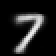

In [7]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height)).resize((56, 56))


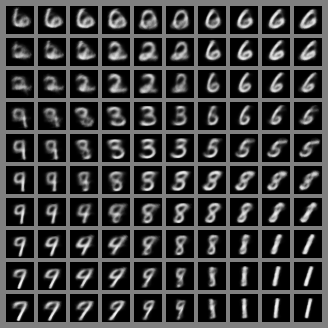

In [8]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth))
for x in range(num_cells):
    vec[:, 0] = (x * 3) / (num_cells - 1) - 1.5
    for y in range(num_cells):
        vec[:, 1] = (y * 3) / (num_cells - 1) - 1.5
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [9]:
def ConditionalVariationalAutoEncoder(num_pixels, num_labels):
    pixels = Input(shape=(num_pixels,))
    label = Input(shape=(num_labels,), name='label')

    inputs = concat(name='inputs')([pixels, label])
    
    encoder_hidden = Dense(512, activation='relu', name='encoder_hidden')(inputs)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return(0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1))

    def reconstruction_loss(y_true, y_pred):
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    zc = concat()([z, label])
    
    decoder_hidden = Dense(512, activation='relu')

    reconstruct_pixels = Dense(num_pixels, activation='sigmoid')

    decoder_in = Input(shape=(latent_space_depth + num_labels,))
    hidden = decoder_hidden(decoder_in)
    decoder_out = reconstruct_pixels(hidden)
    decoder = Model(decoder_in, decoder_out)    
    
    hidden = decoder_hidden(zc)
    outputs = reconstruct_pixels(hidden)
    auto_encoder = Model([pixels, label], outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

cond_auto_encoder, cond_decoder = ConditionalVariationalAutoEncoder(x_train.shape[1], y_train.shape[1])
cond_auto_encoder.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(250, 2), (None, 10)]

In [ ]:
cond_auto_encoder.fit([x_train, y_train], x_train, verbose=1, 
                      batch_size=batch_size, epochs=50,
                      validation_data = ([x_test, y_test], x_test))

In [ ]:
number_4 = np.zeros((1, latent_space_depth + y_train.shape[1]))
number_4[:, 4 + latent_space_depth] = 1
decode_img(cond_decoder.predict(number_4).reshape(
               img_width, img_height)).resize((56, 56))

In [ ]:
number_8_3 = np.zeros((1, latent_space_depth + y_train.shape[1]))
number_8_3[:, 8 + latent_space_depth] = 0.5
number_8_3[:, 3 + latent_space_depth] = 0.5
decode_img(cond_decoder.predict(number_8_3).reshape(
               img_width, img_height)).resize((56, 56))

In [ ]:
digits = [3, 0, 8, 9]
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
for x in range(num_cells):
    x1 = [x / (num_cells - 1), 1 - x / (num_cells - 1)]
    for y in range(num_cells):
        y1 = [y / (num_cells - 1), 1 - y / (num_cells - 1)]
        for idx, dig in enumerate(digits):
            vec[:, dig + latent_space_depth] = x1[idx % 2] * y1[idx // 2]
        decoded = cond_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [ ]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

img_it = 0
vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
for x in range(num_cells):
    vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
    vec[:, x + latent_space_depth] = 1
    for y in range(num_cells):
        vec[:, 1] = 3 * y / (num_cells - 1) - 1.5
        decoded = cond_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview